In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [6]:
Leer = 0
if Leer == 0:
    # Leer el archivo ignorando el encabezado, 9 skiprows
    dfs = [pd.read_csv(f"Datos\Toma_nueva_reflector\Final_Toma_M2_1h\Run{i}_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python") for i in range(1,61)]

    df = pd.concat(dfs, ignore_index=True)
    df.to_parquet('Datos\Toma_nueva_reflector\Final_Toma_M2_1h\Toma_datos_1h.parquet')
df

,Brd,Ch,LG,HG,Tstamp_us,TrgID,NHits
0,0,0,48,49,10230.36,0.0,64.0
1,0,1,53,53,NaN,NaN,NaN
2,0,2,764,3995,NaN,NaN,NaN
3,0,3,46,47,NaN,NaN,NaN
4,0,4,51,45,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8038011,0,59,49,54,NaN,NaN,NaN
8038012,0,60,56,52,NaN,NaN,NaN
8038013,0,61,43,60,NaN,NaN,NaN
8038014,0,62,51,54,NaN,NaN,NaN


In [ ]:
# funcion secundaria encontrar la posición de la incidencia de un muon (centro de carga) 
def conteo(res, evento, n_counts, range_can): # imagen (x,y), el evento a revisar, cantidad de conteos totales, rango de canales activados
    
    n = len(evento) # cantidad de canales activados en el evento
    lix = [i for i in evento if i <= 28] # canales 0-28
    liy = [i for i in evento if i >= 32 and i <= 60] # canales 32-60
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if len(lix) in range_can[0] and len(liy) in range_can[1] and len(lix)+len(liy)!=2:
        
        # Se hace un subdiccionario para los dos ejes y dos listas para la diferencia de indice entre
        # los canales adyacentes para discriminar si son contiguos: la suma debe dar la cantidad de canales -1
        x = {}
        y = {}
        difx = []
        dify = []
        ant = 0
        for llave, valor in evento.items():
            if llave <= 28:
                x[llave] = valor
                if len(x) >= 2:
                    difx.append(llave - ant)
            elif llave >= 32 and llave <= 60:
                y[llave] = valor
                if len(y) >= 2:
                    dify.append(llave - ant)
                
            ant = llave
        
        # Discrimina si son contiguos: la suma debe dar la cantidad de canales -1
        if sum(difx) == len(x)-1 and sum(dify) == len(y)-1:
            
            # Se suman los el producto de la posición del canal (#canal*2cm) y la carga asociada
            # y se divide por la cantidad de canales del evento
            
            carga_x = np.array(list(x.values()))
            carga_y = np.array(list(y.values()))
            pos_x = sum(carga_x * (np.array(list(x.keys())) + 1) * 2) / sum(carga_x) # sumar 1 para que el canal 0 sea 2cm
            pos_y = sum(carga_y * (np.array(list(y.keys())) - 31) * 2) / sum(carga_y) # restar 31 para que el canal 32 sea 2cm
            
            carga = sum(carga_x) + sum(carga_y)
            val = [pos_x, pos_y,carga]
            res = np.vstack([res,val])

            n_counts.append(n)

    
    return res, n_counts


def resolucion(df, range_can, td_hg, td_lg):
    # respuesta imagen (x,y,carga)
    res_h = np.empty((0, 3))
    res_l = np.empty((0, 3))
    
    # Lista de cantidad de canales activados por disparo con HG y LG
    n_counts_h= [] 
    n_counts_l= [] 
    
    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total_h = {}
    conteo_total_l = {}

    # Se llenan los disccionarios
    for i in range(65):
        conteo_total_h[i] = 0
        conteo_total_l[i] = 0
    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in range(int(len(df)/64)):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG o LG
        hg_event = {}
        lg_event = {}
        
        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H/L gain
            hg = df["HG"].values[i*64 + j]
            lg = df["LG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if hg > td_hg:
                hg_event[j] = hg
            if lg > td_lg:
                lg_event[j] = lg
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total_h[len(hg_event)] += 1
        conteo_total_l[len(lg_event)] += 1
        
        conteo_total = [conteo_total_h,conteo_total_l]
        
        # Posiciones de los muones
        res_h, n_counts_h = conteo(res_h, hg_event, n_counts_h, range_can)
        res_l, n_counts_l = conteo(res_l, lg_event, n_counts_l, range_can)
    
    datos_h = res_h, n_counts_h
    datos_l = res_l, n_counts_l     
       
    return datos_h, datos_l, conteo_total

In [6]:
td_hg, td_lg = 1000, 150
range_can = [[2],[2]]
df = pd.read_parquet('Datos\Resolucion_M2\sin_plomo\Toma_12h\Toma_datos_1h.parquet', engine='pyarrow')
total = resolucion(df, range_can, td_hg, td_lg)

with open("Datos\Resolucion_M2\sin_plomo\Toma_12h\Resolucion.pkl", "wb") as f:
    pickle.dump(total, f)

In [22]:
td_hg, td_lg = 1000, 150
df = pd.read_parquet('Datos\Resolucion_M2\sin_plomo\Toma_12h\Toma_datos_1h.parquet', engine='pyarrow')
df = df.head(int(((len(df)/64)//12)*64))
efi_sin = eficiencias(df, td_hg, td_lg)

df = pd.read_parquet('Datos\Resolucion_M2\plomo\Toma_13h\Toma_datos_1h.parquet', engine='pyarrow')
df = df.head(int(((len(df)/64)//13)*64))
efi_plomo = eficiencias(df, td_hg, td_lg)

with open("Datos\Resolucion_M2\sin_plomo\Toma_12h\efi.pkl", "wb") as f:
    pickle.dump(efi_sin, f)
    
with open("Datos\Resolucion_M2\plomo\Toma_13h\efi.pkl", "wb") as f:
    pickle.dump(efi_plomo, f)

In [2]:
with open("Datos\Resolucion_M2\plomo\Toma_13h\Resolucion_34.pkl", "rb") as f:
    total = pickle.load(f)
with open("Datos\Resolucion_M2\sin_plomo\Toma_12h\Resolucion_34.pkl", "rb") as f:
    ori_total = pickle.load(f)

with open("Datos\Resolucion_M2\sin_plomo\Toma_12h\efi.pkl", "rb") as f:
    efi_sin = pickle.load(f)
with open("Datos\Resolucion_M2\plomo\Toma_13h\efi.pkl", "rb") as f:
    efi_plomo = pickle.load(f)

datos_h, datos_l, conteo_total = total
res_h, n_counts_h = datos_h
res_l, n_counts_l = datos_l
conteo_total_h, conteo_total_l = conteo_total

ori_datos_h, ori_datos_l, ori_conteo_total = ori_total
ori_res_h, ori_n_counts_h = ori_datos_h
ori_res_l, ori_n_counts_l = ori_datos_l
ori_conteo_total_h, ori_conteo_total_l = ori_conteo_total

In [ ]:
# Eventos toma de datos con plomo
x = res_h[:,0]
y = res_h[:,1]
car = res_h[:,2]

# Eventos toma sin plomo
ox = ori_res_h[:,0]
oy = ori_res_h[:,1]
ocar = ori_res_h[:,2]  

# Ajustar la cantidad de eventos ya que fue tomada 12 horas para el plomo mientras que 13 horas para el sin plomo
can = int(len(x)/13)*12
x = x[:can]
y = y[:can]

# Cantidad de bins
bins = 30 # Cantidad de bins por eje
bin_size = 60/bins # Tamaño por eje 60cm

# Grilla
x0 = np.linspace(0, 60, bins+1)
y0 = np.linspace(0, 60, bins+1)

# Inicializar la matriz de conteo
matriz_res = np.zeros((bins+1, bins+1))
matriz_ori = np.zeros((bins+1, bins+1))

matriz_res_con = np.zeros((bins+1, bins+1))
matriz_ori_con = np.zeros((bins+1, bins+1))

# Clasificar manualmente cada punto (x, y) por el indice de su bin (discretización)
for k in range(len(ox)):
    oi = int(round(ox[k]/bin_size,0))
    oj = int(round(oy[k]/bin_size,0))
    
    # carga promedio por evento depositada
    """aport_posx = efi_sin[int((ox[k]/2)+0.99)]
    aport_posy = efi_sin[int(((oy[k]/2)+32)+0.99)]
    aport_antx = efi_sin[int((ox[k]/2))]
    aport_anty = efi_sin[int(((oy[k]/2)+32))]
    
    aport = (aport_antx + aport_posx + aport_anty + aport_posy)/4"""
    
    matriz_ori_con[oi, oj] += 1
    matriz_ori[oi, oj] += car[k]


for k in range(len(x)):   
    
    i = int(round(x[k]/bin_size,0))
    j = int(round(y[k]/bin_size,0))
    
    # carga promedio por evento depositada
    """aport_posx = efi_plomo[int((x[k]/2)+0.99)]
    aport_posy = efi_plomo[int(((y[k]/2)+32)+0.99)]
    aport_antx = efi_plomo[int((x[k]/2))]
    aport_anty = efi_plomo[int(((y[k]/2)+32))]
    
    aport = (aport_antx + aport_posx + aport_anty + aport_posy)/4"""
    
    matriz_res_con[i, j] += 1
    matriz_res[i, j] += car[k]


# flatfield
with np.errstate(divide='ignore', invalid='ignore'):
    #matriz_ori = matriz_ori/matriz_ori_con  # normaliza la matriz de conteo por el número de eventos
    #matriz_res = matriz_res/matriz_res_con # normaliza la matriz de conteo por el número de eventos
    
    matriz = matriz_res / matriz_ori  
    matriz[~np.isfinite(matriz)] = 0 # reemplaza NaNs e infs por 0
    
    matriz_con = matriz_res_con / matriz_ori_con  
    matriz_con[~np.isfinite(matriz_con)] = 0

    matriz_tot = (matriz_res/matriz_res_con)/(matriz_ori/matriz_ori_con)
    matriz_tot[~np.isfinite(matriz_tot)] = 0
    
    err_matriz = np.sqrt((matriz_res/(matriz_ori)**2) + (matriz_res**2/(matriz_ori)**3 )) # error de la matriz
    err_matriz[~np.isfinite(err_matriz)] = 0 # reemplaza NaNs e infs por 0


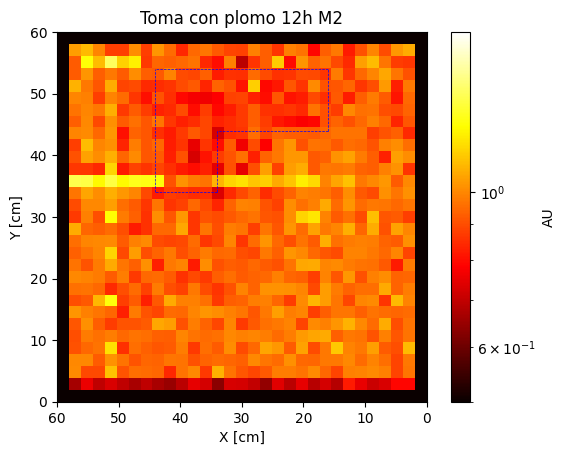

In [ ]:
from matplotlib.colors import LogNorm
#, clim=(0.5,1.5) , norm=LogNorm(vmin=0.5, vmax=1.5) #posibles plots

matriz_con[matriz_con == 0] = 1e-6
# Se hace una transposición dado que inicialmente la posición 0,0 está en la esquina superior izquierda>
plt.imshow(matriz_con[::-1, ::-1].T, extent=[60,0,0,60], cmap="hot", norm=LogNorm(vmin=0.5, vmax=1.7))

#guía de la posición de los bloques
plt.plot([34, 44], [34, 34], color='Blue', linestyle='--', linewidth=0.5)
plt.plot([34, 34], [34, 44], color='Blue', linestyle='--', linewidth=0.5)
plt.plot([16, 34], [44, 44], color='Blue', linestyle='--', linewidth=0.5)
plt.plot([16, 16], [44, 54], color='Blue', linestyle='--', linewidth=0.5)
plt.plot([16, 44], [54, 54], color='Blue', linestyle='--', linewidth=0.5)
plt.plot([44, 44], [34, 54], color='Blue', linestyle='--', linewidth=0.5)
plt.colorbar(label='AU')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.title('Toma con plomo 12h M2')
plt.show()

Promedio de valores por pixel dentro y fuera del area del plomo

In [8]:
m1 = matriz_con[34:44,39:54]
p1 = np.mean(m1)
error_m1 = np.std(m1, ddof=1) / np.sqrt(m1.size)

m2 = matriz_con[16:34,44:54]
p2 = np.mean(m2)
error_m2 = np.std(m2, ddof=1) / np.sqrt(m2.size)

pm = (p1+p2)/2
error_pm = 0.5*np.sqrt(error_m1**2 + error_m2**2)

mt = matriz_con[5:55,5:30]
pt = np.mean(mt)

pm, error_pm, pt

(0.8543513943188394, 0.007127335850238406, 0.9738038558119825)

Escogencia de trancisión de borde

Text(0.5, 1.0, 'Sección de transición borde del plomo')

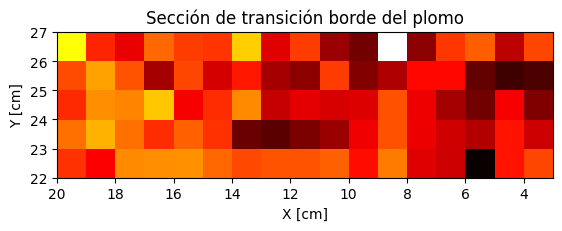

In [6]:
#desde 18-30 en x y de 35-54 cm en y
#plt.imshow(matriz_con[15:33,25:53][::-1, :], extent=[25,53,15,33], cmap="hot")
plt.imshow(matriz_con[3:20,22:27][:, ::-1].T, extent=[20,3,22,27], cmap="hot")
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.title('Sección de transición borde del plomo')

Fit de función de trancisión de borde

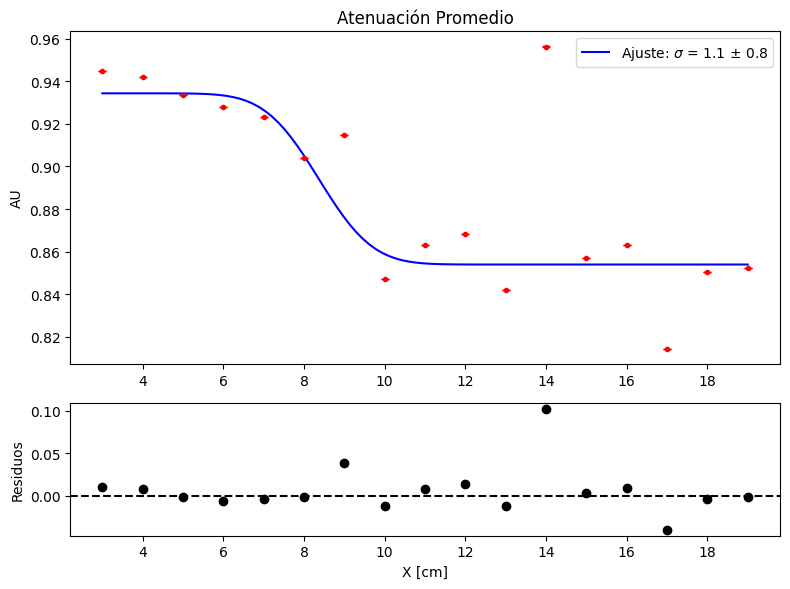

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import erf

resolucion_matriz = matriz_con[3:20,22:27]
resolucion = np.mean(resolucion_matriz, axis=1)

resolucion_err_matriz = err_matriz[3:20,22:27]
error_promedio = np.std(resolucion_err_matriz, axis=1) / np.sqrt(resolucion_matriz.shape[0])

x = np.array(range(len(resolucion)))+3

# Ajuste de la función exponencial a los datos
def func(x, I0, I_max, x0, sigma):
    return I0 + (I_max / 2) * erf((x - x0) / (np.sqrt(2) * sigma))

# Ajustar la función a los datos, teniendo en cuenta los errores de y
popt, pcov = curve_fit(func, x, resolucion, sigma=error_promedio, p0=[0.5, 1, 8, 1])
I0_fit, I_max_fit, x0_fit, sigma_fit = popt

# Calcular el error en cada parámetro (raíz cuadrada de la diagonal de la matriz de covarianza)
perr = np.sqrt(np.diag(pcov))
sigma_err = perr[3]

x_fit = np.linspace(min(x), max(x), 100)
y_fit = func(x_fit, *popt)

y_fit_res = func(x, *popt)

fig1, ax1 = plt.subplots(2, 1, figsize=(8,6), height_ratios=[1, 0.4])  # Reducir el tamaño del gráfico de residuos

# Graficar el primer subgráfico (Atenuación Promedio)
ax1[0].errorbar(x, resolucion, yerr=error_promedio, fmt='.', 
             capsize=3, color='red')
ax1[0].plot(x_fit, y_fit, color='blue', label=f'Ajuste: $\sigma$ = {sigma_fit:.1f} $\pm$ {round(sigma_err,1)}')
ax1[0].set_ylabel('AU')
ax1[0].set_title('Atenuación Promedio')
ax1[0].legend()

# Graficar el segundo subgráfico (Residuos)
ax1[1].scatter(x, resolucion-y_fit_res, color='black')
ax1[1].axhline(y=0, color='black', linestyle='--')
ax1[1].set_xlabel("X [cm]")
ax1[1].set_ylabel("Residuos")

# Ajustar los márgenes entre los subgráficos si es necesario
plt.tight_layout()

